This notebook is part of the PyImageJ [Tutorial Series](./notebooks.rst), and assumes familiarity with the ImageJ API. Dedicated tutorials for ImageJ can be found [here](https://imagej.net/tutorials/).

# 6 Working with Images

These methods can be helpful, especially if you do not know beforehand of which type your image is. First let's initialize ImageJ, import some packages and load in some test data.

In [1]:
import imagej

# initialize ImageJ2
ij = imagej.init(mode='interactive')
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.13.1/1.54d


## 6.1 Opening images with `ij.io().open()`

Images can be opened with ImageJ with `ij.io().open()`. This returns the opened image as an ImageJ2 `Dataset` (a Java object). Using `ij.io().open()` allows you to take advantage of the `Bio-Formats` image read/write and `SCIFIO` image conversion when using Fiji endpoints (_e.g._ `sc.fiji:fiji`). Lets load some data:

_The sample images used in this notebook are available on the PyImageJ GitHub repository [here](https://github.com/imagej/pyimagej/tree/main/doc/sample-data)._

In [2]:
# load local test data
dataset = ij.io().open('sample-data/test_timeseries.tif')

# load web test data
web_image = ij.io().open('https://wsr.imagej.net/images/Cell_Colony.jpg')

[INFO] Populating metadata


[java.lang.Enum.toString] [INFO] Populating metadata


You can also open images using the legacy ImageJ opener with `ij.IJ.openImage()` which will return the older `ImagePlus` Java object type instead of the `Dataset` Java object.

In [3]:
# open image with legacy opener
imp = ij.IJ.openImage('sample-data/test_timeseries.tif')

## 6.2 Displaying images with PyImageJ

PyImageJ has two primary ways of displaying images after they have been loaded:

- ImageJ's image viewer (`ij.ui().show()`)
    - Java
    - Supports _n_-dimensional image data
    - Only available when PyImageJ is initialized in `interactive` mode or `gui` mode for MacOS users
- matplotlib's `pyplot` (`ij.py.show()`)
    - Python
    - Supports 2D image data (_e.g._ X and Y only)

Let's display the images we loaded.

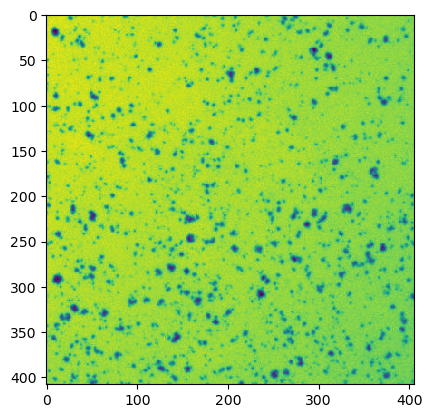

In [4]:
# show the web image
ij.py.show(web_image)

The `ij.py.show` function also supports passing a custom color map e.g. `cmap='hsv'` with the [same syntaxes as matplotlib](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

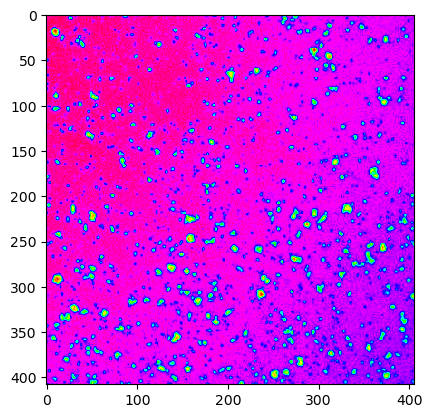

In [5]:
# show the web image with 'hsv' cmap
ij.py.show(web_image, cmap='hsv')

In [6]:
# show the 4D dataset in ImageJ's viewer
ij.ui().show(dataset)

Note that ImageJ's viewer only works locally.

## 6.3 Displaying images dynamically with `ipywidgets`

The ipywidgets library lets us add interactive elements such as sliders to our notebook. Let's build a plane viewer for N-dimensional data.

In [7]:
def plane(image, pos):
    """
    Slices an image plane at the given position.
    :param image: the image to slice
    :param pos: a dictionary from dimensional axis label to element index for that dimension
    """
    # Convert pos dictionary to position indices in dimension order.
    # See https://stackoverflow.com/q/39474396/1207769.
    p = tuple(pos[image.dims[d]] if image.dims[d] in pos else slice(None) for d in range(image.ndim))
    return image[p]

This `plane` function lets us slice an image using its dimensional axis labels. If you're unsure what the axis labels are, you can usually get them by printing the `dims` attribute of the image object.

In [8]:
# get image axis attributes
print(dataset.dims)

('X', 'Y', 'Channel', 'Time')


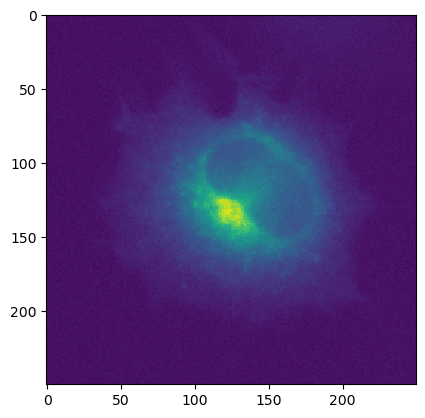

In [9]:
# display channel 1, slice 10
ij.py.show(plane(dataset, {'Channel': 1, 'Time': 10}))

Now that we have this ability, we can script some ipywidget sliders around it:

In [10]:
import ipywidgets

def _axis_index(image, *options):
    axes = tuple(d for d in range(image.ndim) if image.dims[d].lower() in options)
    if len(axes) == 0:
        raise ValueError(f"Image has no {options[0]} axis!")
    return axes[0]

def ndshow(image, cmap=None, x_axis=None, y_axis=None, immediate=False):
    if not hasattr(image, 'dims'):
        # We need dimensional axis labels!
        raise TypeError("Metadata-rich image required")

    # Infer X and/or Y axes as needed.
    if x_axis is None:
        x_axis = _axis_index(image, "x", "col")
    if y_axis is None:
        y_axis = _axis_index(image, "y", "row")

    # Build ipywidgets sliders, one per non-planar dimension.
    widgets = {}
    for d in range(image.ndim):
        if d == x_axis or d == y_axis:
            continue
        label = image.dims[d]
        widgets[label] = ipywidgets.IntSlider(description=label, max=image.shape[d]-1, continuous_update=immediate)

    # Create image plot with interactive sliders.
    def recalc(**kwargs):
        print("displaying")
        ij.py.show(plane(image, kwargs), cmap=cmap)
    ipywidgets.interact(recalc, **widgets)

In [11]:
# display data with ipywidgets
ndshow(dataset)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Channel', max=2), IntSlider(val…

## 6.4 Displaying images via itkwidgets

The [itkwidgets package](https://pypi.org/project/itkwidgets/) provides a powerful viewer for 2D and 3D images, point sets, and geometry. Using it is as simple as importing the `view` function from `itkwidgets`, then calling `view(image)`.

***Note: itkwidgets only works with Python images, not Java images.*** Fortunately, you can use `ij.py.from_java` to convert a Java image to Python before displaying it.

***Note: To run itkwidgets, please install it manually.*** This can be done with pip (`pip install itkwidgets`) or on conda by updating `environment.yml`.

In [12]:
import itkwidgets

itkwidgets.view(ij.py.from_java(web_image))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC2; pr…

## 6.5 Displaying images via napari

<table><tr><td>

This section does not currently work on macOS. See [imagej/pyimagej#197](https://github.com/imagej/pyimagej/issues/197) for details.

</td></tr></table>

The [napari](https://napari.org/) package provides an external viewer for N-dimensional image data. Using it is as simple as importing the `view_image` function from `napari`, then calling `view_image(image)`.

***Note:*** Like `itkwidgets`, `napari` ***only supports Python images, not Java images***. You will need to convert them from Java to Python using `ij.py.from_java(image)`.

Also be aware that as of this writing, napari does not recognize xarray dimensional axis labels, and it also wants a ***different dimension order from the scikit-image convention***; for `cells`, using `(ch, pln, row, col)` works well. You can use `numpy.moveaxis` to adjust the dimension order.

***NOTE:*** To run napari, please install it manually. This can be done with pip (`pip install napari`) or on conda by updating `environment.yml`.

In [13]:
import napari

napari.view_image(ij.py.from_java(web_image))

Viewer(camera=Camera(center=(0.0, 203.5, 202.5), zoom=1.2222956598369685, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 408.0, 1.0), (0.0, 406.0, 1.0)), current_step=(203, 202), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x7f47cd1b05e0>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x7f481e4ca200>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

## 6.6 Inspecting image data

The sample data `test_timeseries.tif` is a 4D (X, Y, Channel, Time) dataset of a HeLa cell infected with a modified HIV-1 fluorescent reporter virus. This reporter virus is designed to express two flourscent proteins upon viral gene expression. Here is the breakdown of the channels:

| Channel | psedu-color | purpose |
| :---: | :---: | :---: |
| 1 | Blue | Nuclear marker |
| 2 | Red | Early viral gene expression |
| 3 | Green | Late viral gene expression / viral particle formation |

Let's first take a look at the `test_timeseries.tif` image data and get important image information such as dimension and shape:

In [14]:
def dump_info(image):
    """A handy function to print details of an image object."""
    name = image.name if hasattr(image, 'name') else None # xarray
    if name is None and hasattr(image, 'getName'): name = image.getName() # Dataset
    if name is None and hasattr(image, 'getTitle'): name = image.getTitle() # ImagePlus
    print(f" name: {name or 'N/A'}")
    print(f" type: {type(image)}")
    print(f"dtype: {image.dtype if hasattr(image, 'dtype') else 'N/A'}")
    print(f"shape: {image.shape}")
    print(f" dims: {image.dims if hasattr(image, 'dims') else 'N/A'}")

dump_info(dataset)

 name: test_timeseries.tif
 type: <java class 'net.imagej.DefaultDataset'>
dtype: <java class 'net.imglib2.type.numeric.integer.UnsignedShortType'>
shape: (250, 250, 3, 15)
 dims: ('X', 'Y', 'Channel', 'Time')


The same methods can also be used on Python objects as well (where dimension information is available):

In [15]:
# convert the ImageJ image (Java) to an xarray.DataArray (Python)
xarr = ij.py.from_java(dataset)

# dump info on xarray.DataArray result from ij.py.from_java()
dump_info(xarr)

 name: test_timeseries.tif
 type: <class 'xarray.core.dataarray.DataArray'>
dtype: uint16
shape: (15, 250, 250, 3)
 dims: ('t', 'row', 'col', 'ch')


**Some important points to note here!**

1. The `dataset`s type is [`net.imagej.DefaultDataset`](https://javadoc.scijava.org/ImageJ2/net/imagej/DefaultDataset.html), a Java class. Notably, this class implements the [`net.imagej.Dataset`](https://javadoc.scijava.org/ImageJ2/net/imagej/Dataset.html) interface, the primary image data type of ImageJ2.

2. The `datasets`'s dtype (i.e. the type of its elements, i.e. what kind of sample values it has) is [`UnsignedShortType`](https://javadoc.scijava.org/ImgLib2/net/imglib2/type/numeric/integer/UnsignedShortType.html), the ImgLib2 class for unsigned 16-bit integer data (i.e. uint16) with integer values in the \[0, 65535\] range.

3. The image is 4-dimensional, 250 × 250, 3 channels, and 15 time points.

4. Note the difference in shape and dimension order between the ImageJ and xarray images. ImageJ images use `[X, Y, Channel, Z, Time]` dimension labels and order. NumPy images use `[t, pln, row, col, ch]` where `row` and `col` correspond to `Y` and `X` respectively.


<table><tr><td>

💡 You can save your data with `ij.io().save(image, filepath)` to save your image data to disk.

</td></tr></table>

## 6.7 Passing image data from Python to Java

In many cases, you will have image data in Python already as a NumPy array, or perhaps as an [xarray](https://docs.xarray.dev/), and want to send it into Java for processing with ImageJ routines. This PyImageJ tutorial assumes you are somewhat familiar with NumPy already; if not, please see _e.g._ [this W3Schools tutorial on NumPy](https://www.w3schools.com/python/numpy/) to learn about NumPy before proceeding.

In the next cell, we will open an image as a NumPy array using the [scikit-image](https://scikit-image.org/) library.

In [16]:
import skimage
cells = skimage.data.cells3d()
dump_info(cells)

 name: N/A
 type: <class 'numpy.ndarray'>
dtype: uint16
shape: (60, 2, 256, 256)
 dims: N/A


Because this sample image is a NumPy array, but not an xarray, it does not have dimensional axis labels. However, scikit-image has [defined conventions](https://scikit-image.org/docs/dev/user_guide/numpy_images.html#coordinate-conventions) for the order of dimensions as follows:

    (t, pln, row, col, ch)

Where `t` is time, `pln` is plane/Z, `row` is row/Y, `col` is column/X, and `ch` is channel.

Now that we are armed with that knowledge, notice that `cells` actually has a slightly different dimension order, with planar rather than interleaved channels: `(pln, ch, row, col)`. Let's construct an xarray from this image that includes the correct dimensional axis labels:

In [17]:
import xarray
xcells = xarray.DataArray(cells, name='xcells', dims=('pln', 'ch', 'row', 'col'))
dump_info(xcells)

 name: xcells
 type: <class 'xarray.core.dataarray.DataArray'>
dtype: uint16
shape: (60, 2, 256, 256)
 dims: ('pln', 'ch', 'row', 'col')


Now to wrap this image as a Java object. We will use PyImageJ's `ij.py.to_java(data)` function, which wraps the image ***without making a copy***. This means that you can modify the original NumPy array values, and the same changes will automatically be reflected on the Java side as well.

In [18]:
# send image data to Java
jcells = ij.py.to_java(cells)
jxcells = ij.py.to_java(xcells)

# dump info
print("[jcells]")
dump_info(jcells)
print("\n[jxcells]")
dump_info(jxcells)

[jcells]
 name: N/A
 type: <java class 'net.imagej.DefaultDataset'>
dtype: <java class 'net.imglib2.type.numeric.integer.UnsignedShortType'>
shape: (256, 256, 2, 60)
 dims: ('X', 'Y', 'Unknown', 'Unknown')

[jxcells]
 name: xcells
 type: <java class 'net.imagej.DefaultDataset'>
dtype: <java class 'net.imglib2.type.numeric.integer.UnsignedShortType'>
shape: (256, 256, 2, 60)
 dims: ('X', 'Y', 'Channel', 'Z')


Let's take a look at what happened here:

* The `cells`, a numpy array, became an `Img<UnsignedShortType>`, an ImgLib2 image type without metadata.
* The `xcells`, an xarray, became a `Dataset`, an ImageJ2 rich image type with metadata including dimensional labels.

In both cases, notice that the dimensions were reordered. PyImageJ makes an effort to respect the scikit-image dimension order convention where applicable, including ***reordering dimensions between ImageJ2 style and scikit-image style*** when translating images between worlds.

In ImageJ-style terminology, the `ZCYX` order becomes `XYCZ`, because ***ImageJ2 indexes dimensions from fastest to slowest moving***, whereas ***NumPy indexes them from slowest to fastest moving***. In both worlds, iterating over this image's samples will step through columns first, then rows, then channels, then focal planes—the only difference is the numerical order of the dimensions.

These differences between conventions can be confusing, so ***pay careful attention to your data's dimensional axis types***.

Note that `ij.py.to_java` supports various data types beyond only images:

| Python type        | Java type                          | Notes |
|--------------------|------------------------------------|-------|
| `numpy.ndarray`    | `net.imglib2.img.Img`              | An `Img` is both a `RandomAccessibleInterval` and an `IterableInterval`. |
| `xarray.DataArray` | `net.imagej.Dataset`               | A `Dataset` is an `Img` with additional metadata including dimensional axis labels. |
| `int`              | `Integer`, `Long`, or `BigInteger` | Destination Java type depends on magnitude of the integer. |
| `float`            | `Float`, `Double`, or `BigDecimal` | Destination Java type depends on magnitude and precision of the value. |
| `str`              | `String`                           |       |
| `bool`             | `boolean`                          |       |
| `dict`             | `LinkedHashMap`                    | Converted recursively (i.e., elements of the dict are converted too). |
| `set`              | `LinkedHashSet`                    | Converted recursively (i.e., elements of the set are converted too). |
| `list`             | `ArrayList`                        | Converted recursively (i.e., elements of the list are converted too). |

But ***only images are wrapped without copying data***.

## 6.8 Passing image data from Java to Python

To translate a Java image into Python, use:

```python
python_image = ij.py.from_java(java_image)
```

It's the opposite of `ij.py.to_java`:

* Metadata-rich images such as `Dataset` become xarrays.
* Plain metadata-free images (e.g. `Img`, `RandomAccessibleInterval`) become NumPy arrays.
* Generally speaking, Java types in the table above become the corresponding Python types.

Let's compare `xcells` (original Python image), `jxcells` (image converted to Java) and a new conversion `xcells_2` (`jxcells` converted back to Python with `ij.py.from_java()`).

In [19]:
# convert jxcells back to Python
xcells_2 = ij.py.from_java(jxcells)

print("[xcells - original Python image]")
dump_info(xcells)
print("\n[jxcells - after conversion to Java]")
dump_info(jxcells)
print("\n[xcells_2 - conversion back to Python]")
dump_info(xcells_2)

[xcells - original Python image]
 name: xcells
 type: <class 'xarray.core.dataarray.DataArray'>
dtype: uint16
shape: (60, 2, 256, 256)
 dims: ('pln', 'ch', 'row', 'col')

[jxcells - after conversion to Java]
 name: xcells
 type: <java class 'net.imagej.DefaultDataset'>
dtype: <java class 'net.imglib2.type.numeric.integer.UnsignedShortType'>
shape: (256, 256, 2, 60)
 dims: ('X', 'Y', 'Channel', 'Z')

[xcells_2 - conversion back to Python]
 name: xcells
 type: <class 'xarray.core.dataarray.DataArray'>
dtype: uint16
shape: (60, 256, 256, 2)
 dims: ('pln', 'row', 'col', 'ch')


Notice the difference? The `xcells` dimension order is ZCYX, which flipped to XYCZ when passed to Java. But when passed back to Python, the C dimension was shuffled to the end of the list (_i.e._ top of the stack). The reason is:
    
***PyImageJ makes a best effort to reorganize image dimensions to match scikit-image conventions.*** The dimensions TZYXC are shuffled to the top with that precedence; any other dimensions are left in place behind those. This behavior is intended to make it easier to use converted Python images with Python-side tools like scikit-image and napari.

So again: ***pay careful attention to your data's dimensional axis types***.

## 6.9 Direct image type conversions

PyImageJ's `to_java()` and `from_java()` Python helper methods will attempt to provide you with the best conversion possible for the image object in question. While this allows for quick conversions between Java and Python objects, you lose the option to specify what output image type to create. For scenarios where a specific image output type is desired its best to use the direct image converters: `to_dataset()`, `to_img()`, `to_imageplus()` and `to_xarray()`. The direct image converts accept both Java and Python image objects (_e.g._ `net.imagej.Dataset`, `numpy.ndarray`, `xarray.DataArray`, `ij.ImagePlus`, _etc_...) and optionaly a `dim_order`  (a list of dimensions as strings) keyword argument. The `dim_order` option can be used by a direct image converter to poperly shuffle the dimensions into their expected positions.

For example, RGB images as NumPy arrays do not have any axes or dimension metadata and get mangled during the conversion process to an ImageJ Java object (like a `net.imagej.Dataset`). This is because the PyImageJ's default behavior for converting images without axes/dimension information is to assume a general `('t', 'pln', 'row', 'col', 'ch')` organization to the data and inverts the order. An RGB image with shape `(100, 250, 3)` converted to a `net.imagej.Dataset` without dimension order information will return with shape `(3, 250, 100)`. Attempting to display this in ImageJ's viewer will produce crazy results as ImageJ expects the first two dimensions to be `X` and `Y`. But in this case the first two dimensions are `Channel` and `Y`! This can be resolved by performing the same image conversion but with a `dim_order=['row', 'col', 'ch']`.

**Example direct image conversion**

```python
# dataset is some n-dimensional net.imagej.Dataset
xarr = ij.py.to_xarray(dataset)
```

**Example direct image conversion with `dim_order`**

```python
# rgb_image is some 3 channel image as a Numpy array
rgb_dataset = ij.py.to_dataset(rgb_image, dim_order=['row', 'col', 'ch'])
```

Converting images between Java, Python and the various image object types is confusing (especially when the dimensions and array shape are likely to change). Below are tables that outline the expected behavior of the direct image converters. For the following tables the input example data is cropped from the `test_timeseries.tif` example dataset, found in the [PyImageJ](https://github.com/imagej/pyimagej/tree/main/doc/sample-data) repository, to shape `(250, 100, 3, 15)` with dimensions`('X', 'Y', 'Channel', 'Time')`.


**Python -> Java direct image conversions**

| Input type | Input dimensions/shape | Hints | Method | Output type | Output dimensions/shape |
| ---------- | ---------------------- | ----- | ------ | ----------- | ----------------------- |
| `numpy.ndarray` | No `dims` attribute / `(15, 100, 250, 3)` | _None_ | `to_dataset()` | `net.imagej.Dataset` | `('dim_3', 'dim_2', 'dim_1', 'dim_0')` / `(3, 250, 100, 15)` |
| `numpy.ndarray` | No `dims` attribute / `(15, 100, 250, 3)` | `dim_order=['t', 'row', 'col', 'ch']` | `to_dataset()` | `net.imagej.Dataset` | `('X', 'Y', 'Time', 'Channel')` / `(250, 100, 15, 3)` |
| `numpy.ndarray` | No `dims` attribute/ `(15, 100, 250, 3)` | `dim_order=['t', 'row']` | `to_dataset()` | `net.imagej.Dataset` | `('dim_1', 'dim_0', 'Y', 'Time')` / `(3, 250, 100, 15)` |
| `numpy.ndarray` | No `dims` attribute / `(15, 100, 250, 3)` | _None_ | `to_img()` | `net.imglib2.img.ImgView` | No `dims` attribute / `(3, 250, 100, 15)` |
| `numpy.ndarray` | No `dims` attribute / `(15, 100, 250, 3)` | `dim_order=['t', 'row', 'col', 'ch']` | `to_img()` | `net.imglib2.img.ImgView` | No `dims` attribute / `(250, 100, 15, 3)` |
| `numpy.ndarray` | No `dims` attribute / `(15, 100, 250, 3)` | `dim_order=['t', 'row']` | `to_img()` | `net.imglib2.img.ImgView` | No `dims` attribute / `(3, 250, 100, 15)` |
| `xarray.DataArray` | `('t', 'row', 'col', 'ch')` / `(15, 100, 250, 3)` | _None_ | `to_dataset()` | `net.imagej.Dataset` | `('X', 'Y', 'Time', 'Channe')` / `(250, 100, 15, 3)` |
| `xarray.DataArray` | `('t', 'row', 'col', 'ch')` / `(15, 100, 250, 3)` | `dim_order=['t', 'row', 'col', 'test']` | `to_dataset()` | `net.imagej.Dataset` | `('test', 'X', 'Y', 'Time')` / `(3, 250, 100, 15)` |
| `xarray.DataArray` | `('t', 'row', 'col', 'ch')` / `(15, 100, 250, 3)` | `dim_order=['t', 'row']` | `to_dataset()` | `net.imagej.Dataset` | `('dim_1', 'dim_0', 'Y', 'Time')` / `(3, 250, 100, 15)` |
| `xarray.DataArray` | `('t', 'row', 'col', 'ch')` / `(15, 100, 250, 3)` | _None_ | `to_img()` | `net.imglib2.img.ImgView` | No `dims` attribute / `(250, 100, 15, 3)` |
| `xarray.DataArray` | `('t', 'row', 'col', 'ch')` / `(15, 100, 250, 3)` | `dim_order=['t', 'row', 'col', 'test']` | `to_img()` | `net.imglib2.img.ImgView` | No `dims` attribute / `(3, 250, 100, 15)` |

**Java -> Python direct image conversions**

| Input type | Input dimensions/shape | Hints | Method | Output type | Output dimensions/shape |
| ---------- | ---------------------- | ----- | ------ | ----------- | ----------------------- |
|`net.imagej.Dataset` | `('X', 'Y', 'Channel', 'Time')` / `(250, 100, 3, 15)` | _Not supported_ | `to_xarray()` | `xarray.DataArray` | `('t', 'row', 'col', 'ch')` / `(15, 100, 250, 3)` |
|`net.imagej.ImgPlus` | `('X', 'Y', 'Channel', 'Time')` / `(250, 100, 3, 15)` | _Not supported_ | `to_xarray()` | `xarray.DataArray` | `('t', 'row', 'col', 'ch')` / `(15, 100, 250, 3)` |
|`net.imglib2.img.Img` | No `dims` attribute / `(250, 100, 3, 15)` | _Not supported_ | `to_xarray()` | `xarray.DataArray` | `('dim_0', 'dim_1', 'dim_2', 'dim_3')` / `(15, 3, 100, 250)` |
|`ij.ImagePlus` | `('X', 'Y', 'C', 'T')` / `(250, 100, 3, 15)` | _Not supported_ | `to_xarray()` | `xarray.DataArray` | `('t' ,'row', 'col', 'ch')` / `(15, 100, 250, 3)` |

## 6.10 Slicing Java and Python images

NumPy supports a powerful slicing operation, which lets you focus on a subset of your image data. You can crop image planes, work with one channel or time point at a time, limit the range of focal planes, and more.

If you are not already familiar with NumPy array slicing, please peruse the [NumPy slicing tutorial on W3Schools](https://www.w3schools.com/python/numpy/numpy_array_slicing.asp) to get familiar with it.

Here are some quick examples using the `test_timeseries.tif` 4D dataset with dimensions (X, Y, Channel, Time):

| Syntax                         | Result                                | Shape             |
|--------------------------------|---------------------------------------|-------------------|
| `image`                        | the image without any slicing         | (250, 250, 3, 15) |
| `image[:, :, 0, :]`            | channel 0 (blue - nucleus)            | (250, 250, 15)    |
| `image[:, :, -1, :]`           | last channel (green - viral proteins) | (250, 250, 15)    |
| `image[100:200, 100:200,: ,:]` | cropped 100 x 100 4D image, centered  | (100, 100, 3, 15) |

Let's slice and crop the `test_timeries.tif` (loaded as the `dataset` Java object) using NumPy array slicing.

channel 1, time point 3


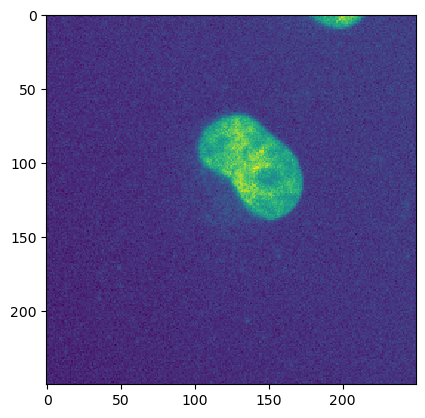

100 x 100 crop, channel 1, time point 3


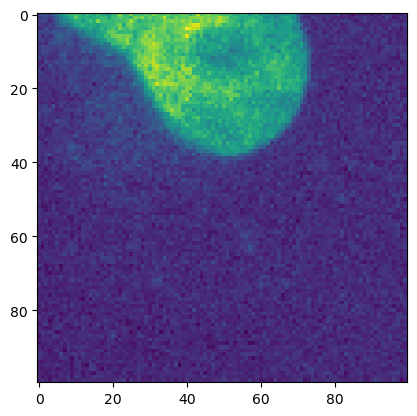

In [20]:
# channel 1, time point 3
s1 = dataset[:, :, 0, 3]

# 100 x 100 crop, channel 1, time point 3
s2 = dataset[100:200, 100:200, 0, 3]

print("channel 1, time point 3")
ij.py.show(s1)
print("100 x 100 crop, channel 1, time point 3")
ij.py.show(s2)

`s1` and `s2` are Java objects sliced from an image with (X, Y, Channel , Time) dimensions.

In [21]:
type(s1)

<java class 'net.imglib2.view.IntervalView'>

In [22]:
# slice the test data
java_slice = dataset[:, :, 1, 10]
python_slice = xarr[10, :, :, 1]

# print slice shape
print(f"java_slice: {java_slice.shape}")
print(f"python_slice: {python_slice.shape}")

java_slice: (250, 250)
python_slice: (250, 250)


**Important**: When you slice an ImageJ image (_i.e._ a `RandomAccessibleInterval`) an `IntervalView` is returned. Depending on what you're doing this object type could be and you can continue with your workflow. In this case however, we need to wrap/convert the `IntervalView` returned from the slicing operation as an `ImgPlus`. Then we can use `ij.py.show()` to view the slice. For more information on `RandomAccessibleIntervals` check out the ImageJ wiki [here](https://imagej.net/libs/imglib2/accessibles).

java_slice type: <java class 'net.imglib2.view.IntervalView'>


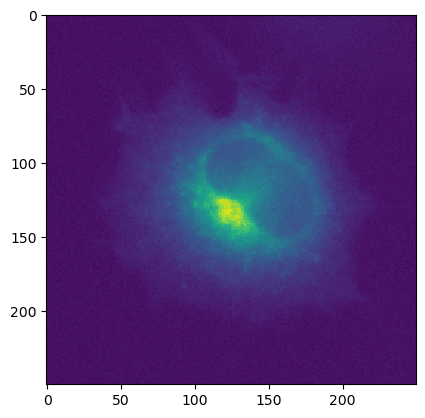

In [23]:
print(f"java_slice type: {type(java_slice)}")

# wrap as ImgPlus -- you can also wrap the slice as a dataset with ij.py.to_dataset()
img = ij.py.to_img(java_slice)
ij.py.show(img)

python_slice type: <class 'xarray.core.dataarray.DataArray'>


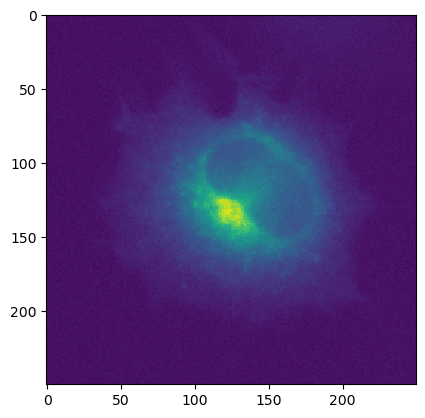

In [24]:
print(f"python_slice type: {type(python_slice)}")

# xarray images can just be displayed
ij.py.show(python_slice)

## 6.11 Combine slices

With `xarray` you can combine slices easily using the `.concat()` operation. Let's take two slices from the 4D dataset and create a new 3D xarray.

In [25]:
# get two slices from the test dataset
xarr_slice1 = xarr[12, :, :, 1]
xarr_slice2 = xarr[12, :, :, 2]

# these slices should only be 2D (i.e. x,y)
print(f"s1 shape: {xarr_slice1.shape}")
print(f"s2 shape: {xarr_slice2.shape}")

s1 shape: (250, 250)
s2 shape: (250, 250)


Import `xarray` and combine the two extracted frames.

In [26]:
import xarray as xr

# note that you must specify which coordnate ('dim') to concatenate on
new_stack = xr.concat([xarr_slice1[:,:], xarr_slice2[:,:]], dim='ch')

Now we can check the dimensions of the new 3D image.

In [27]:
print(f"Number of dims: {len(new_stack.dims)}\ndims: {new_stack.dims}\n shape: {new_stack.shape}")

Number of dims: 3
dims: ('ch', 'row', 'col')
 shape: (2, 250, 250)


`ij.py.show()` only displays 2D images, not 3D ones like `new_stack`. But we can view both slices of `new_stack` like so:

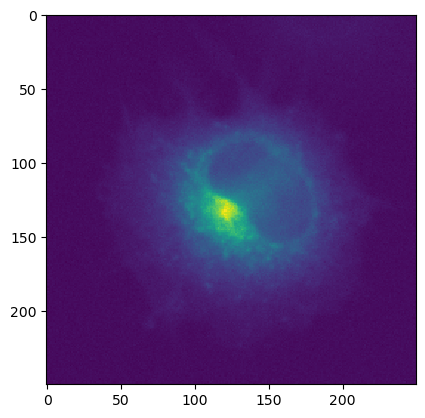

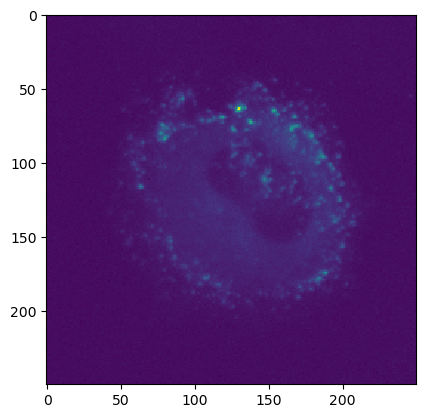

In [28]:
# view the data
ij.py.show(new_stack[0])
ij.py.show(new_stack[1])

Remeber we can send `new_stack` back to ImageJ/Java with `ij.py.to_java()` for further analysis

In [29]:
# send new_stack back to ImageJ/Java
img = ij.py.to_java(new_stack)
print(f"img dims: {img.dims}\nimg shape: {img.shape}")

img dims: ('X', 'Y', 'Channel')
img shape: (250, 250, 2)


You can also combine slices from ImageJ images using ImgLib2's `Views.stack()` function. `stack` accepts two or more n-dimensional `RandomAccessibleIntervals` of the same size and returns a (n+1)-dimensional `RandomAccessibleInterval` where the last dimension is the index of the input hyperslices.

First let's use `scyjava` to import the `net.imglib2.view.Views` class. You can learn more about this specific class and other ImgLib2 classes at the [ImgLib2 Javadoc](https://javadoc.scijava.org/ImgLib2/).

In [30]:
import scyjava as sj

Views = sj.jimport('net.imglib2.view.Views')

Next let's slice the original dataset (dimensions:  X, Y, Channel, Time) to extract two slices to combine into a new stack.

In [31]:
jslice_1 = dataset[:, :, 1, 12]
jslice_2 = dataset[:, :, 2, 12]
print(f"slice 1 shape: {jslice_1.shape}\nslice 2 shape: {jslice_2.shape}")

slice 1 shape: (250, 250)
slice 2 shape: (250, 250)


Now we can use `Views` to combine the two slices into a new stack.

In [32]:
jstack = Views.stack(jslice_1, jslice_2)
print(f"stack shape: {jstack.shape}")

stack shape: (250, 250, 2)


Note the new 3rd dimension, the index of the slices (_i.e._ the channel dimension).

Finally we can view the contents of the new stack:

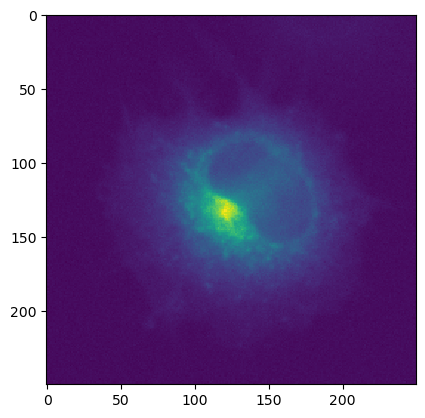

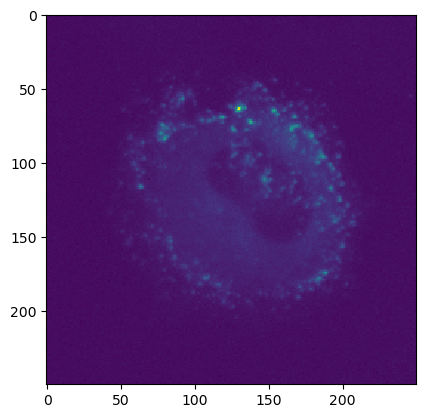

In [33]:
# view the two slices jstack
ij.py.show(ij.py.to_img(jstack[:, :, 0]))
ij.py.show(ij.py.to_img(jstack[:, :, 1]))

## 6.12 Create numpy images

`ij.py.initialize_numpy_image()` takes a single image argument and returns a NumPy array of zeros in the same shape as the input image. This method is used internally when sending/recieving data with `ij.py.to_java()` and `ij.py.from_java()` to initialize a destination NumPy array. An important nuance to know is that `RandomAccessibleIntervals` passed to `initialize_numpy_image()` will return a NumPy array with a **reversed** shape. When passing `xarray.DataArray` or `numpy.ndarray` images will return a NumPy array of zeros in the **same** shape as the input array.

In [34]:
# initialize a new numpy array with numpy array
new_arr1 = ij.py.initialize_numpy_image(xarr.data)

# initialize a new numpy array with xarray
new_arr2 = ij.py.initialize_numpy_image(xarr)

# initialize a numpy array with RandomeAccessibleInterval
new_arr3 = ij.py.initialize_numpy_image(dataset)

print(f"xarr/numpy shape: {xarr.shape}\ndataset shape: {dataset.shape}")
print(f"new_arr1 shape: {new_arr1.shape}\nnew_arr2 shape: {new_arr2.shape}\nnew_arr3 shape: {new_arr3.shape}")

xarr/numpy shape: (15, 250, 250, 3)
dataset shape: (250, 250, 3, 15)
new_arr1 shape: (15, 250, 250, 3)
new_arr2 shape: (15, 250, 250, 3)
new_arr3 shape: (15, 3, 250, 250)


Note that both `new_arr1` and `new_arr2` have the same shape as the source `xarr`. `new_arr3` however has reversed dimensions relative to `dataset` (a `RandomAcessibleInterval`).

## 6.13 Working with ops

PyImageJ also grants easy access to `imagej-ops`. Using `ij.py.to_java()` to convert Python objects into Java ones for ops allows you to utilize the full power of `imagej-ops` on Python-based `xarray.DataArray` and `numpy.ndarray` data.

In [35]:
import numpy as np

arr1 = np.array([[1, 2], [3, 4]])
arr2 = np.array([[5, 6], [7, 8]])
arr_output = ij.py.initialize_numpy_image(arr1)

ij.op().run('multiply', ij.py.to_java(arr_output), ij.py.to_java(arr1), ij.py.to_java(arr2))
print(arr_output) # this output will be [[5, 12], [21, 32]]

[[ 5 12]
 [21 32]]


## 6.14 Window service and manipulating windows

In order to use a graphical user interface, you must also initialize PyImageJ with `mode='gui'` or `mode='interactive'`. To work with windows, you can:

* Use ImageJ2's
  [`WindowService`](https://javadoc.scijava.org/ImageJ/net/imagej/display/WindowService.html) through `ij.window()`.

* Use the original ImageJ's
[`WindowManager`](https://javadoc.scijava.org/ImageJ1/index.html?ij/WindowManager.html) using the `ij.WindowManager` property.

Please note that the original ImageJ's `WindowManager` was not designed to operate in a headless enviornment, thus some functions my not be supported.

You can get a list of active ImageJ2 windows with the following command:

In [36]:
print(ij.window().getOpenWindows())

[test_timeseries.tif]


To close windows use this command:

In [37]:
ij.window().clear()